# NAO example notebook

This notebook contains an example of access of ERA5 data with the `Teleconnection` class and evaluation of the NAO teleconnection (station based index) with `aqua` libraries and an example of the plotting routines for one experiment only.

## Content

* [The load of packages, modules, and data](#load)
* [Data retrieve](#retrieve)
* [Index evaluation](#index-evaluation)
* [Regression evaluation](#regression)
   * [Regression seasonal evaluation](#regression-seasonal-evaluation)
* [Correlation evaluation](#correlation-evaluation)
* [Comparison with NCAR data](#comparison-with-ncar-data)

## The load of packages, modules, and data <a class="anchor" id="load"></a>

The only import needed is the `Teleconnection` class from the `teleconnections` module.

In [1]:
from teleconnections import Teleconnection

### Teleconnection details configuration

To run a teleconnection analysis, we only need to specify the teleconnection name and the catalog entry to be loaded by the `Reader` inside the class.

Details such as teleconnection coordinates, folder input/output are obtained with functions collected in the `tools` module, that access details from a `yaml` file.

A configuration file is provided in the `config` folder. By default the `teleconnections-destine.yaml` file is used to specify the teleconnection details and the variables to be loaded. The file can be changed with the `interface` argument of the `Teleconnection` class.

A command line interface is provided in the `cli` folder, with a `yaml` file for access of a specific teleconnection analysis and experiment.

The minimum amount of information needed to run a teleconnection analysis is the teleconnection name and the catalog entry to be loaded by the `Reader` inside the class.
Note that with this minimum amount of information data will be loaded with no regridding or time aggregation, so be sure to access a source with roughly 1 degree resolution and monthly frequency.
Custom regridding and time aggregation can be specified with `regrid='r100` and `freq='monthly'` arguments in the `Teleconnection` class.

In [2]:
telecname = 'NAO'

model = 'ERA5'
exp = 'era5'
source = 'monthly'

### Initialize the class

Data required for the NAO teleconnection are retrieved with the `Reader` class from the `AQUA` framework in the `retrieve` method of the class.

A logger is initialized to print out information on the screen.
We keep here `loglevel='INFO'` in order to print out what is happening in the notebook, but it can avoided and fall back to the default `loglevel='WARNING'` to avoid printing out useless information in a production environment.

In [3]:
telec = Teleconnection(model=model, exp=exp, source=source, telecname=telecname, loglevel='INFO')

2024-02-25 19:04:54 :: Teleconnection :: INFO     -> No regrid will be performed, be sure that the data is already at low resolution
2024-02-25 19:04:54 :: Teleconnection :: INFO     -> No time aggregation will be performed, be sure that the data is already at the desired frequency
2024-02-25 19:04:54 :: Teleconnection :: INFO     -> No time aggregation will be performed, be sure that the data is already at the desired frequency
2024-02-25 19:04:54 :: Teleconnection :: INFO     -> Namelist loaded
2024-02-25 19:04:55 :: Reader :: INFO     -> Fix names in metadata is ERA5-destine-v1
2024-02-25 19:04:55 :: Reader :: INFO     -> Fix names ERA5-destine-v1 found in fixes files
2024-02-25 19:04:55 :: Reader :: INFO     -> Grid metadata is era5-r025
2024-02-25 19:04:58 :: Teleconnection :: INFO     -> Reader initialized


## Data retrieve <a class="anchor" id="retrieve"></a>

Data are accessed with the AQUA `Reader` class, that is initialized with the `Teleconnection` class.
This is totally transparent to the user. Any evaluation (index, regression, correlation) is retrieving data automatically but here we will retrieve data calling explicitly the method to show how it works.
Notice also that the logging level is passed to the `Reader` class and other fuctions, so that information about the data retrieval is printed out as well.

In [4]:
telec.retrieve()

2024-02-25 19:05:56 :: Reader :: INFO     -> Retrieving variables: ['msl']
2024-02-25 19:05:58 :: Reader :: INFO     -> Variables to be fixed: {'msl': {'grib': True, 'source': 'MSL'}}
2024-02-25 19:05:58 :: Reader :: INFO     -> msl: converting units Pa --> Pa
2024-02-25 19:05:58 :: Reader :: INFO     -> coordinates adjusted to cf by AQUA fixer
2024-02-25 19:05:58 :: Teleconnection :: INFO     -> Data retrieved


The data are stored as `xarray` objects in the `data` attribute of the class, since they will be used by other methods.

In [5]:
telec.data

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 996, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2022-12-01
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    msl      (time, lat, lon) float32 4GB dask.array<chunksize=(12, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Wed Dec 06 11:40:11 2023: cdo -O -s -f nc4 -z zip -cat /wor...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

## Index evaluation

We now show the individual steps of the teleconnection analysis and plot the results.

The NAO index can be evaluated by using the library function `station_based_index` from the `index.py` file.
The index can be evaluated with a custom rolling window to average data (standard is 3 months, it can be specified as argument `month_windows` while initializing the Teleconnection class).

In [6]:
telec.evaluate_index()

2024-02-25 19:07:53 :: Teleconnection :: INFO     -> Index evaluated


The index is stored in the `self.index` attribute of the class since it's needed by the regression and correlation methods and an internal method `plot_index` to plot the index is provided.

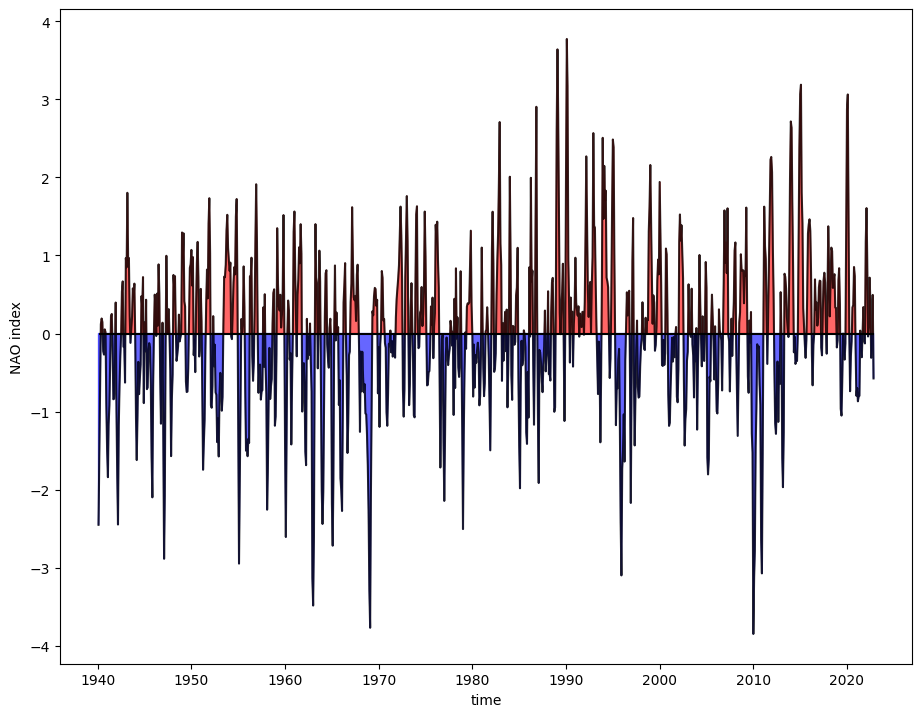

In [7]:
telec.plot_index()

## Regression evaluation <a class="anchor" id="regression"></a>

Also in this case, a specific method of the class is available to evaluate the regression map. Since no other method is called, the regression map is not stored in the class, but it is returned by the method as an `xarray` object.

In [8]:
reg = telec.evaluate_regression()

Since in the most common case we want to compare the regression map with some other experiments or observations, we don't have an internal method to plot a single regression map, but a function in the diagnostic is provided to plot a map for a single experiment.

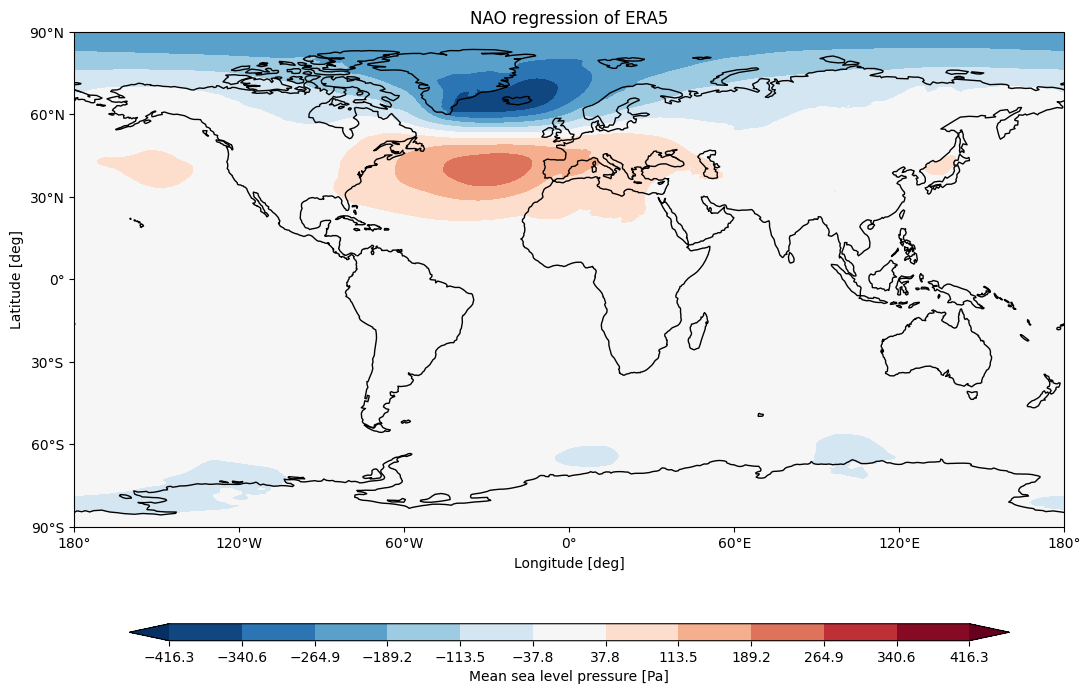

In [9]:
from aqua.graphics import plot_single_map

plot_single_map(data=reg, title='NAO regression of ERA5', sym=True)

### Regression seasonal evaluation <a class="anchor" id="regression-seasonal-evaluation"></a>

The regression map can be evaluated for a season by specifying the `season` argument in the `evalutate_regression` method. The accepted format is by using the initial letter of the months of the selected season, e.g. `season='DJF'`.

In [10]:
reg_djf = telec.evaluate_regression(season='DJF')

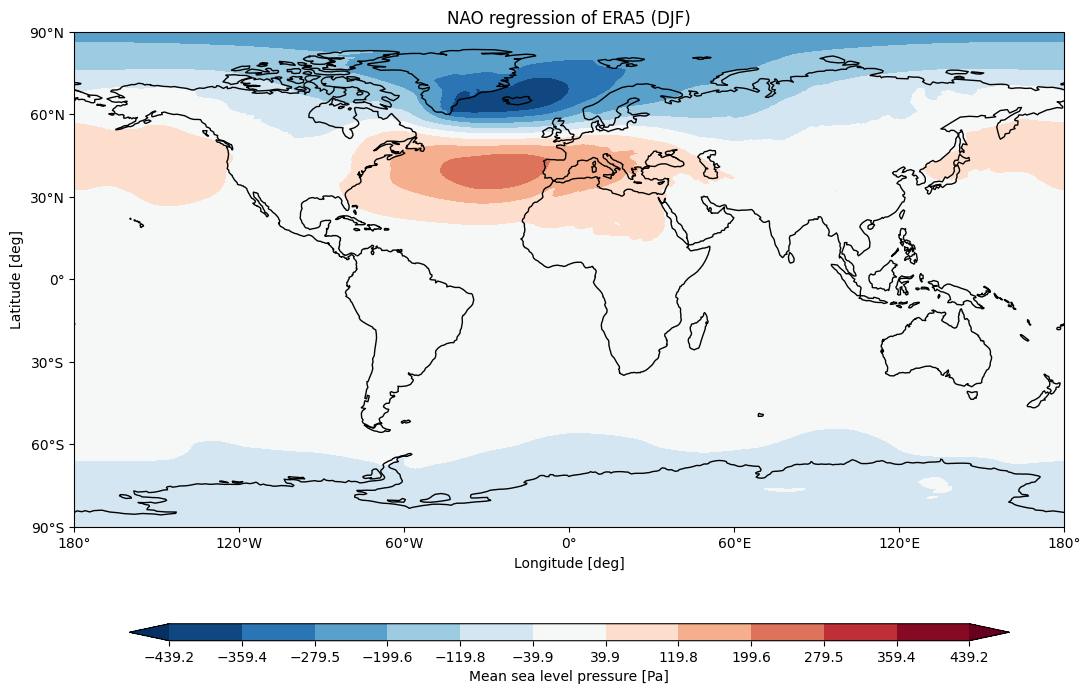

In [11]:
plot_single_map(data=reg_djf, title='NAO regression of ERA5 (DJF)', sym=True)

## Correlation evaluation <a class="anchor" id="correlation-evaluation"></a>

Also in this case, a specific method of the class is available to evaluate the regression map. Since no other method is called, the regression map is not stored in the class, but it is returned by the method as an `xarray` object.
Season can be specified as in the regression case.

In [12]:
cor = telec.evaluate_correlation()

As before we don't have an internal method to plot a single correlation map, but the same function as before can be used.

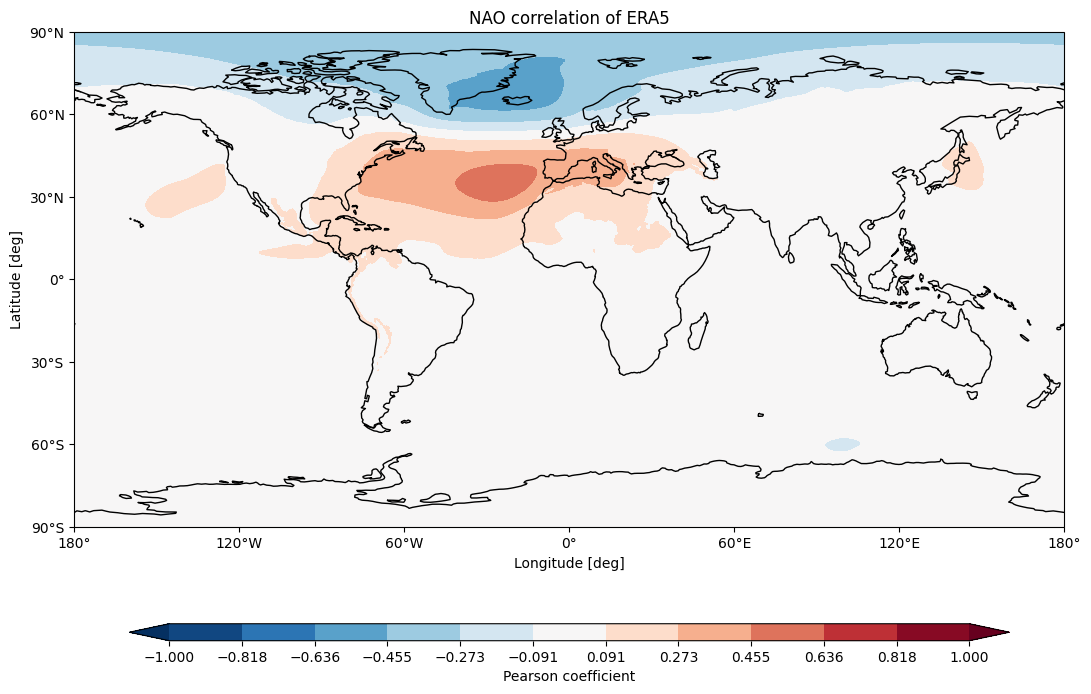

In [13]:
plot_single_map(data=cor, cbar_label='Pearson coefficient', title='NAO correlation of ERA5', vmin=-1, vmax=1)

## Comparison with NCAR data

With the NAO index computed, we can compare with observational data from NCAR, to check if the index is computed correctly.
NCAR data are available in the `data` folder of the diagnostic.

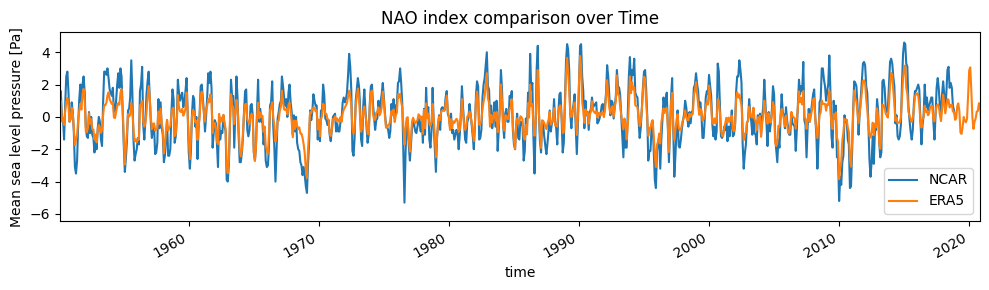

In [15]:
import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

ncar_path = '../data/nao_station_seasonal.txt'
nao_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

year = nao_ncar[:,0]
month_data = nao_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
nao_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,3))
plt.plot(datetimes, nao_ncar.values,label='NCAR')

plt.xlim(datetime.datetime(1950, 1, 31, 0, 0),datetime.datetime(2020, 10, 31, 0, 0))

telec.index.plot(label='ERA5')
plt.legend()
plt.title('NAO index comparison over Time')
fig.tight_layout()

plt.show()